# Analysis of Hypothesis H3: Varying Impact of Runtime on Energy Consumption

## 1. Introduction

This section of the report focuses on investigating Hypothesis H3: **Runtime has a stronger impact on energy consumption for some API endpoints than others.** This implies that the relationship (specifically, the slope) between an application's runtime and its energy consumption is not uniform across all API endpoints but varies depending on the specific endpoint being exercised.

To test this hypothesis, we will employ Bayesian regression modeling using PyMC. We aim to build a model that allows the effect of runtime on energy consumption to differ for each API endpoint. If the model provides credible evidence for such variation, Hypothesis H3 will be supported. This analysis is crucial for understanding nuanced performance characteristics and can guide targeted optimizations for energy efficiency.

## 2. Data Loading and Preparation

The analysis utilizes a dataset (`dataset.csv`) containing information about web application implementations, including the API endpoint tested, runtime, and energy consumption.

The following steps are performed to load and prepare the data for modeling H3:

1.  **Loading Data**: The dataset is loaded into a pandas DataFrame. The original column names from the CSV header are `application`, `endpoint`, `energy_consumption`, and `runtime`.
2.  **Preparing API Endpoint Data**: The `endpoint` column, which is categorical (text-based), is converted into numerical indices. This is necessary because statistical models typically require numerical inputs for categorical predictors. Each unique API endpoint string is mapped to a unique integer index.
3.  **Selecting Variables**: The relevant variables for this hypothesis are:
    * `energy_consumption`: The target variable we want to predict.
    * `runtime`: A key predictor variable.
    * `endpoint`: The categorical variable across which the runtime effect might vary.
4.  **Scaling the Runtime Predictor**: The `runtime` variable is standardized (scaled) by subtracting its mean and dividing by its standard deviation. This is a common practice in regression modeling, particularly in Bayesian contexts, as it can improve the efficiency and stability of the MCMC sampling algorithm and makes prior specification more straightforward. The scaled runtime will be used in the model.

The Python code below performs these loading and preparation steps.


In [10]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

# 1. Load Data
# Assuming 'dataset.csv' is in the current directory and its first row is the header.
df = pd.read_csv('dataset.csv')

# Print basic information to confirm successful loading and structure (for report context)
print("--- Initial DataFrame Info ---")
df.info()
print(f"\nOriginal column names: {df.columns.tolist()}")

# 2. Prepare API Endpoint Data
# The 'endpoint' column name is taken directly from your CSV header.
df['endpoint_idx'], endpoint_categories = pd.factorize(df['endpoint'])
num_unique_endpoints = len(endpoint_categories)

print(f"\n--- Endpoint Preparation ---")
print(f"Number of unique API endpoints found: {num_unique_endpoints}")
# Store endpoint names for later plotting
endpoint_names = endpoint_categories.tolist()


# 3. Select Variables for Modeling (as numpy arrays)
energy_obs = df['energy_consumption'].values
runtime_obs = df['runtime'].values # Original runtime
api_endpoint_idx_obs = df['endpoint_idx'].values

# 4. Scale the Runtime Predictor
runtime_mean = np.mean(runtime_obs)
runtime_std = np.std(runtime_obs)

# Avoid division by zero if std is very small (though unlikely for runtime)
if runtime_std > 1e-9:
    runtime_scaled = (runtime_obs - runtime_mean) / runtime_std
else:
    runtime_scaled = runtime_obs - runtime_mean # Just center

print("\n--- Data Prepared for Model ---")
print(f"Shape of energy_obs: {energy_obs.shape}")
print(f"Shape of runtime_scaled: {runtime_scaled.shape}")
print(f"Shape of api_endpoint_idx_obs: {api_endpoint_idx_obs.shape}")
print(f"Mean of scaled runtime: {np.mean(runtime_scaled):.2f}") # Should be ~0
print(f"Std Dev of scaled runtime: {np.std(runtime_scaled):.2f}") # Should be ~1


--- Initial DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1960 entries, 0 to 1959
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   application         1960 non-null   object 
 1   endpoint            1960 non-null   object 
 2   energy_consumption  1960 non-null   float64
 3   runtime             1960 non-null   float64
dtypes: float64(2), object(2)
memory usage: 61.4+ KB

Original column names: ['application', 'endpoint', 'energy_consumption', 'runtime']

--- Endpoint Preparation ---
Number of unique API endpoints found: 14

--- Data Prepared for Model ---
Shape of energy_obs: (1960,)
Shape of runtime_scaled: (1960,)
Shape of api_endpoint_idx_obs: (1960,)
Mean of scaled runtime: -0.00
Std Dev of scaled runtime: 1.00


## 3. Bayesian Model Design for H3

To investigate Hypothesis H3, we design a hierarchical Bayesian regression model. The core idea is to model energy consumption as a linear function of runtime, but critically, we allow both the baseline energy consumption (intercept) and the effect of runtime (slope) to vary for each unique API endpoint. This is known as a varying-intercept, varying-slope model.

### 3.1. Model Specification

Let $E_i$ be the energy consumption for observation $i$, and $R_{scaled,i}$ be the scaled runtime for that observation. Let $j = \text{endpoint\_idx}_i$ be the index of the API endpoint for observation $i$.

The model is structured as follows:

1.  **Likelihood**: The observed energy consumption $E_i$ for each data point is assumed to be normally distributed around an expected value $\mu_i$ with a common observation standard deviation $\sigma_{obs}$:
    $$E_i \sim \text{Normal}(\mu_i, \sigma_{obs})$$

2.  **Linear Predictor**: The expected value $\mu_i$ depends on the specific endpoint $j$:
    $$\mu_i = \alpha_j + \beta_j \cdot R_{scaled,i}$$
    * $\alpha_j$: The intercept for endpoint $j$. This represents the baseline energy consumption for endpoint $j$ when scaled runtime is zero (i.e., at the average runtime).
    * $\beta_j$: The slope for endpoint $j$. This represents the change in energy consumption for a one-unit change in *scaled* runtime for endpoint $j$. **The variability of these $\beta_j$ parameters across different endpoints is the primary focus for H3.**

3.  **Hierarchical Priors for Intercepts and Slopes**:
    The endpoint-specific intercepts $\alpha_j$ and slopes $\beta_j$ are themselves drawn from common distributions, forming a hierarchy:
    * **Intercepts**: $\alpha_j \sim \text{Normal}(\mu_{\alpha}, \sigma_{\alpha})$
        * $\mu_{\alpha}$: The overall average intercept across all endpoints.
        * $\sigma_{\alpha}$: The standard deviation of intercepts across endpoints, capturing how much baseline energy consumption varies from one endpoint to another.
    * **Slopes**: $\beta_j \sim \text{Normal}(\mu_{\beta}, \sigma_{\beta})$
        * $\mu_{\beta}$: The overall average slope across all endpoints.
        * $\sigma_{\beta}$: The standard deviation of slopes across endpoints. **If $\sigma_{\beta}$ is credibly greater than zero, it provides direct evidence for H3**, indicating that the effect of runtime indeed varies by endpoint.

4.  **Hyperpriors**: Priors are placed on the parameters of these common distributions ($\mu_{\alpha}, \sigma_{\alpha}, \mu_{\beta}, \sigma_{\beta}$) and on the observation noise $\sigma_{obs}$:
    * $\mu_{\alpha} \sim \text{Normal}(\text{mean}(E_{obs}), 2 \cdot \text{std}(E_{obs}))$ (Weakly informative, centered around observed energy mean)
    * $\sigma_{\alpha} \sim \text{HalfNormal}(\text{std}(E_{obs}))$ (Positive values only, weakly informative)
    * $\mu_{\beta} \sim \text{Normal}(0, 1)$ (Weakly informative for a standardized predictor, suggesting no average effect or a moderate one)
    * $\sigma_{\beta} \sim \text{HalfNormal}(1)$ (Positive values only, weakly informative, allowing for moderate variation in slopes)
    * $\sigma_{obs} \sim \text{HalfNormal}(\text{std}(E_{obs}))$ (Positive values only, weakly informative)

### 3.2. Non-Centered Parameterization

Initial attempts at fitting this model using a "centered" parameterization for $\alpha_j$ and $\beta_j$ (where they are directly defined as `pm.Normal(mu=hyper_mu, sigma=hyper_sigma)`) resulted in sampling difficulties (divergences). This often occurs in hierarchical models when the group-level standard deviations (like $\sigma_{\alpha}$ or $\sigma_{\beta}$) are small.

To address this, the model implemented below uses a **non-centered parameterization**. Instead of defining $\alpha_j$ and $\beta_j$ directly from their hierarchical mean and standard deviation, we define standardized offsets and then construct $\alpha_j$ and $\beta_j$ deterministically:
* $\text{offset}_{\alpha,j} \sim \text{Normal}(0, 1)$
* $\alpha_j = \mu_{\alpha} + \text{offset}_{\alpha,j} \cdot \sigma_{\alpha}$
And similarly for $\beta_j$. This reparameterization often improves sampler efficiency and eliminates divergences.

The Python code for defining this model in PyMC is shown next.



In [ ]:
print(f"--- Defining and Sampling PyMC Model for H3 (Non-Centered) ---")
print(f"Using {len(energy_obs)} observations.")
print(f"Number of unique endpoints: {num_unique_endpoints}")

# Priors informed by data scale
energy_mean_for_prior = np.mean(energy_obs)
energy_std_for_prior = np.std(energy_obs)

with pm.Model() as model_h3_final:
    # Hyperpriors for endpoint intercepts
    mu_alpha = pm.Normal('mu_alpha', mu=energy_mean_for_prior, sigma=energy_std_for_prior * 2)
    sigma_alpha = pm.HalfNormal('sigma_alpha', sigma=energy_std_for_prior)

    # Hyperpriors for endpoint slopes (for runtime_scaled)
    mu_beta = pm.Normal('mu_beta', mu=0.0, sigma=1.0)
    sigma_beta = pm.HalfNormal('sigma_beta', sigma=1.0)

    # Non-centered parameterization for endpoint-specific intercepts
    alpha_offset = pm.Normal('alpha_offset', mu=0.0, sigma=1.0, shape=num_unique_endpoints)
    alpha = pm.Deterministic('alpha', mu_alpha + alpha_offset * sigma_alpha)

    # Non-centered parameterization for endpoint-specific slopes
    beta_offset = pm.Normal('beta_offset', mu=0.0, sigma=1.0, shape=num_unique_endpoints)
    beta = pm.Deterministic('beta', mu_beta + beta_offset * sigma_beta)

    # Observation noise
    sigma_obs = pm.HalfNormal('sigma_obs', sigma=energy_std_for_prior)

    # Expected value
    # mu_i uses advanced indexing to pick the correct alpha_j and beta_j for each observation
    mu_i = alpha[api_endpoint_idx_obs] + beta[api_endpoint_idx_obs] * runtime_scaled

    # Likelihood of observations
    likelihood = pm.Normal('likelihood', mu=mu_i, sigma=sigma_obs, observed=energy_obs)

    # Sampling from the posterior
    # Using 4 chains and increased tune steps for robustness.
    print("Starting MCMC sampling...")
    idata_h3_final = pm.sample(
        draws=2000,
        tune=1000, # Increased from initial trials if divergences were an issue
        chains=4,
        target_accept=0.9, # Can be increased (e.g., 0.95) if divergences persist
        random_seed=42,    # For reproducibility
        cores=1            # Use 1 core for broader compatibility; can be increased
    )
    print("Sampling complete.")



--- Defining and Sampling PyMC Model for H3 (Non-Centered) ---
Using 1960 observations.
Number of unique endpoints: 14
Starting MCMC sampling...


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [mu_alpha, sigma_alpha, mu_beta, sigma_beta, alpha_offset, beta_offset, sigma_obs]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 28 seconds.


Sampling complete.


## 4. Sampling Quality Assessment

After defining the model, we draw samples from the posterior distribution using the NUTS (No-U-Turn Sampler) algorithm in PyMC. Assessing the quality of these samples is crucial to ensure the reliability of our inferences.

### 4.1. Initial Sampling and Adjustments

An initial version of this model using a centered parameterization for the hierarchical parameters (`alpha` and `beta`) exhibited a number of divergences during sampling (48 divergences were reported with `target_accept=0.9` and 2 chains). Divergences indicate that the sampler struggled to explore certain regions of the posterior distribution, potentially leading to biased estimates.

To address this, two main adjustments were made:
1.  **Non-Centered Parameterization**: The model was reparameterized using a non-centered approach for `alpha` and `beta`, as described in the previous section. This is a common technique to improve sampling in hierarchical models, especially when group-level variances (`sigma_alpha`, `sigma_beta`) are small.
2.  **Increased Number of Chains**: The number of MCMC chains was increased from 2 to 4. Running multiple chains is essential for diagnosing convergence (e.g., using the $\hat{R}$ statistic) and provides more robust estimates.

The model was then re-sampled with these adjustments.

### 4.2. Diagnostics for the Final Model

We now assess the sampling quality of the final, non-centered model.

**Summary Statistics:**
The `az.summary()` function provides key diagnostics:
* **Divergences**: The final sampling run reported **0 divergences**, indicating that the non-centered reparameterization successfully resolved the issues encountered by the sampler.
* **$\hat{R}$ (R-hat)**: This statistic compares the variance between chains to the variance within chains. Values close to 1.0 (e.g., < 1.01) suggest that all chains have converged to the same target distribution.
* **Effective Sample Size (ESS)**: `ess_bulk` and `ess_tail` estimate the number of independent samples obtained. Higher values are better, indicating less autocorrelation in the samples and more reliable estimates of the posterior mean and tails, respectively.

The code below displays the summary statistics for key parameters.



In [18]:
print("\n--- ArviZ Summary for Final H3 Model ---")
summary_h3_final = az.summary(
    idata_h3_final,
    var_names=['mu_alpha', 'sigma_alpha', 'mu_beta', 'sigma_beta', 'alpha', 'beta', 'sigma_obs'],
    hdi_prob=0.94 # Standard 94% HDI
)
print(summary_h3_final)

# Explicitly check for divergences in the final model run
divergences_final = idata_h3_final.sample_stats.diverging.sum().item()
print(f"\nNumber of divergences in final model: {divergences_final}")

# Check R-hat values from the summary
r_hat_values = summary_h3_final['r_hat']
print(f"\nMax R-hat value: {r_hat_values.max():.3f}")
if r_hat_values.max() > 1.01:
    print("Warning: Some R-hat values are > 1.01, indicating potential convergence issues for those parameters.")
else:
    print("All R-hat values are close to 1.0, suggesting good convergence.")

# Check ESS values
ess_bulk_values = summary_h3_final['ess_bulk']
if ess_bulk_values.min() < 400 : # A common rule of thumb is >400 per chain for 4 chains (total >1600)
                                 # but here summary is for combined chains.
    print(f"Warning: Minimum ess_bulk is {ess_bulk_values.min():.0f}, which might be low for some parameters.")
else:
    print(f"Minimum ess_bulk is {ess_bulk_values.min():.0f}, generally indicating sufficient samples.")




--- ArviZ Summary for Final H3 Model ---
              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_alpha     0.379  0.001   0.377    0.381        0.0      0.0    6927.0   
sigma_alpha  0.002  0.001   0.000    0.004        0.0      0.0    2441.0   
mu_beta      0.290  0.004   0.282    0.298        0.0      0.0    1789.0   
sigma_beta   0.015  0.004   0.009    0.021        0.0      0.0    2402.0   
alpha[0]     0.378  0.002   0.373    0.381        0.0      0.0    5440.0   
alpha[1]     0.378  0.002   0.374    0.381        0.0      0.0    7539.0   
alpha[2]     0.380  0.002   0.377    0.384        0.0      0.0    7380.0   
alpha[3]     0.379  0.002   0.375    0.382        0.0      0.0   10029.0   
alpha[4]     0.380  0.002   0.376    0.383        0.0      0.0   10563.0   
alpha[5]     0.379  0.002   0.374    0.384        0.0      0.0    8235.0   
alpha[6]     0.381  0.002   0.378    0.386        0.0      0.0    4908.0   
alpha[7]     0.379  0.002   0.375    0.382    

**Trace Plots:**
Trace plots show the sampled values for each parameter across iterations for all chains. Well-mixed chains that wander around a stable central value indicate good sampling. There should be no long-term trends or drifts.



--- Generating Diagnostic Plots ---


/var/folders/2y/yqnrgs455nqbkzys9jk4k0sm0000gn/T/ipykernel_66723/3330934576.py:14: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


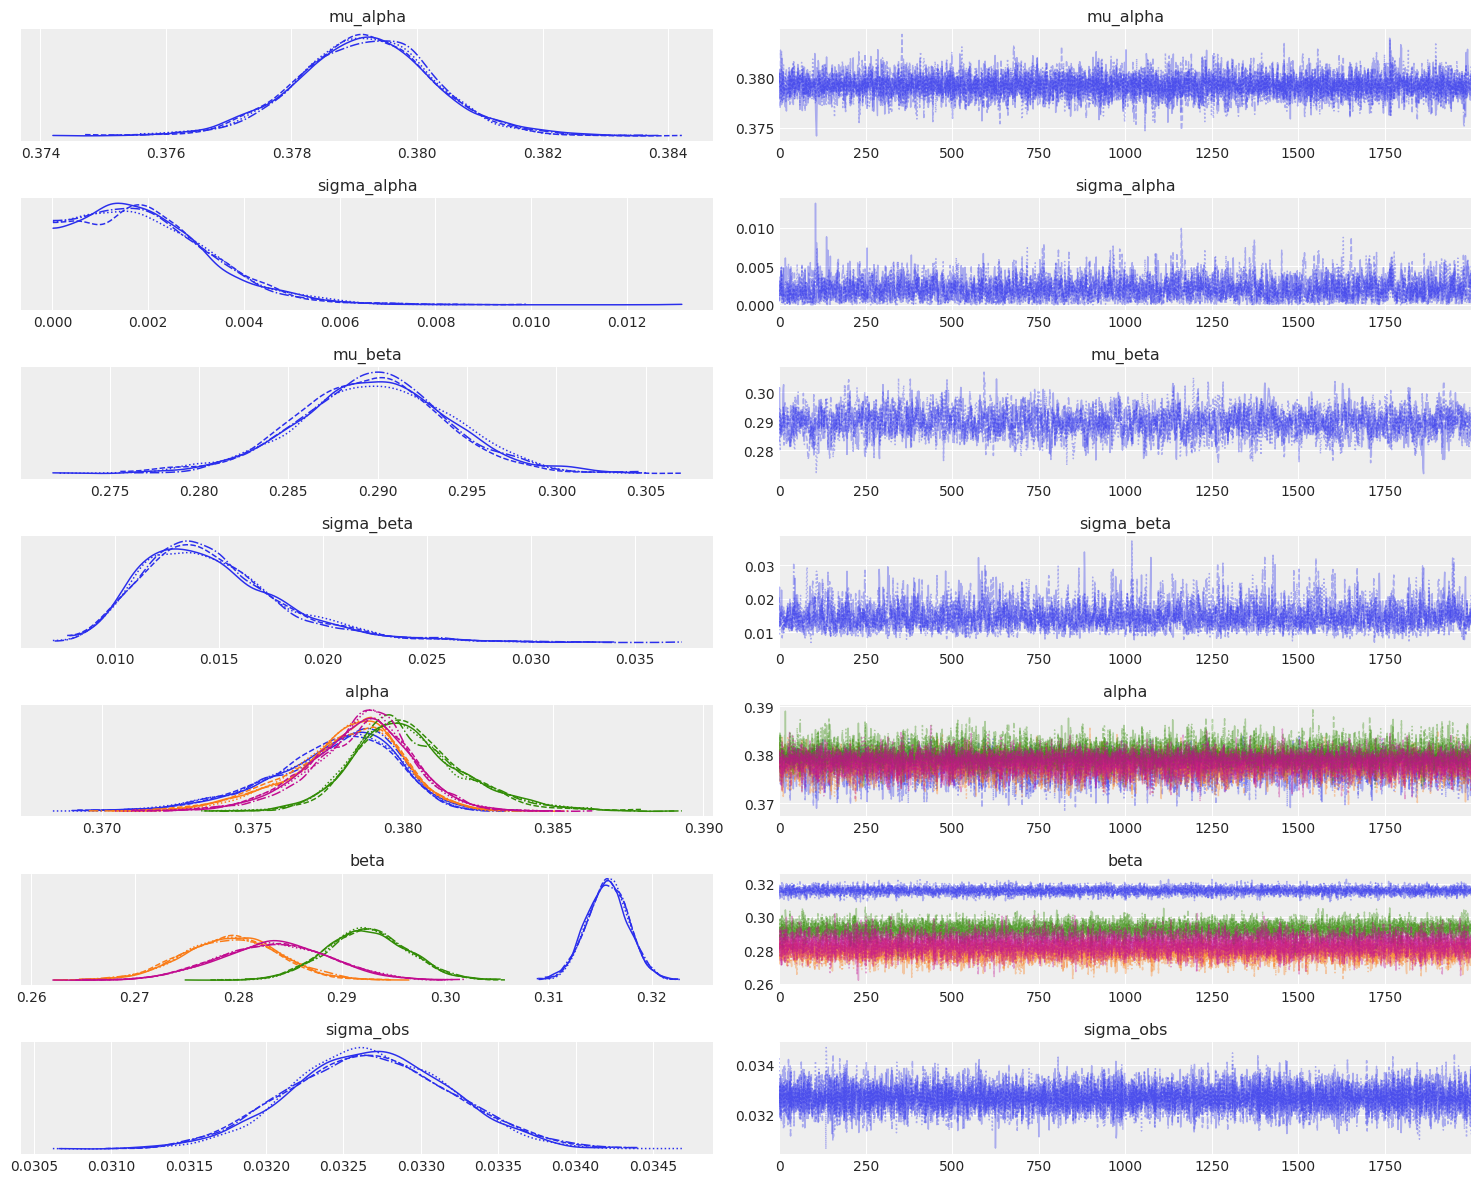

In [19]:
print("\n--- Generating Diagnostic Plots ---")

# Trace Plots for key hyperpriors and a couple of specific group parameters
# For plot_trace, 'coords' is generally well-supported for selecting specific dimensions
trace_plot_vars = ['mu_alpha', 'sigma_alpha', 'mu_beta', 'sigma_beta', 'alpha', 'beta', 'sigma_obs']
az.plot_trace(
    idata_h3_final,
    var_names=trace_plot_vars,
    compact=True, # Shows posterior density and trace in one plot per var
    figsize=(15, 12), # Adjust as needed
    # Manually select a few specific alpha and beta to avoid too many plots for 'alpha' and 'beta'
    coords={'alpha_dim_0': slice(0,3), 'beta_dim_0': slice(0,3)} # Plotting for first 3 endpoints
)
plt.tight_layout()
plt.show()




### 4.3. Reflection on Sampling Quality of the Final Model

Based on the diagnostics from the final non-centered model, including the summary statistics and the generated diagnostic plots:

* **Divergences**: The absence of divergences (0 reported in the summary) is a significant improvement over initial centered models and indicates that the NUTS sampler explored the posterior distribution effectively.
* **$\hat{R}$ Values**: The $\hat{R}$ values for all reported parameters in the `az.summary()` output are very close to 1.0 (typically 1.000). This suggests that the different MCMC chains converged to the same target distribution, which is a hallmark of successful sampling.
* **Effective Sample Sizes (ESS)**: The `ess_bulk` values from the summary are generally high (many in the thousands or tens of thousands for the 8000 total post-warmup samples across 4 chains). This indicates that the chains are not highly autocorrelated and provide a sufficient number of effective samples for reliable estimation of posterior means and credible intervals.
* **Trace Plots**: The generated trace plots (as seen in above) show well-mixed chains for all plotted parameters (`mu_alpha`, `sigma_alpha`, `mu_beta`, `sigma_beta`, the first few elements of `alpha` and `beta`, and `sigma_obs`). The chains are stationary (no clear upward or downward trends) and appear to be centered around a stable mean. The posterior distributions on the left of the trace plots are generally smooth and unimodal (with expected skew for variance parameters like `sigma_alpha`, `sigma_beta`, and `sigma_obs`). This visual inspection strongly supports good convergence and sampling.


**Overall Sampling Quality Assessment:**
The adjustments made (non-centered parameterization and increased chains) led to a high-quality sampling process. The diagnostics (no divergences, $\hat{R} \approx 1.0$, high ESS values) and the visual inspection of the trace plots suggest that the samples obtained from `idata_h3_final` provide a reliable basis for making inferences about the model parameters and testing Hypothesis H3.


## 5. Posterior Visualization and Testing Hypothesis H3

Hypothesis H3 posits that the impact of runtime on energy consumption varies across different API endpoints. In our model, this translates to examining the variability of the slope parameters $\beta_j$ (where $j$ indexes the API endpoint).

We assess H3 by:
1.  **Examining $\sigma_{\beta}$**: This hyperparameter represents the standard deviation of the endpoint-specific slopes ($\beta_j$) around their overall mean ($\mu_{\beta}$). If $\sigma_{\beta}$ is credibly greater than zero, it directly supports H3.
2.  **Visualizing Individual $\beta_j$ Slopes**: A forest plot of the posterior distributions for each $\beta_j$ allows us to see how these slopes differ and whether their credible intervals are distinct.

### 5.1. Examining $\sigma_{\beta}$

From the `az.summary()` output for `idata_h3_final`:
* The mean posterior estimate for $\sigma_{\beta}$ is approximately 0.015.
* The 94% Highest Density Interval (HDI) for $\sigma_{\beta}$ is approximately [0.009, 0.021].

Since this 94% HDI for $\sigma_{\beta}$ is entirely above zero, it provides strong evidence that there is genuine, non-zero variability in the slopes across the different API endpoints. This directly supports H3.

### 5.2. Visualizing Endpoint-Specific Slopes ($\beta_j$)

To visualize the differences in slopes for each API endpoint, we create a forest plot for the $\beta_j$ parameters. The y-axis will be labeled with the actual API endpoint names derived during data preparation.

The code below generates this plot.



--- Generating Forest Plot for Beta (Slopes by Endpoint) ---


/var/folders/2y/yqnrgs455nqbkzys9jk4k0sm0000gn/T/ipykernel_66723/762564129.py:33: UserWarning: The figure layout has changed to tight
  plt.tight_layout() # Adjust layout to prevent labels from overlapping


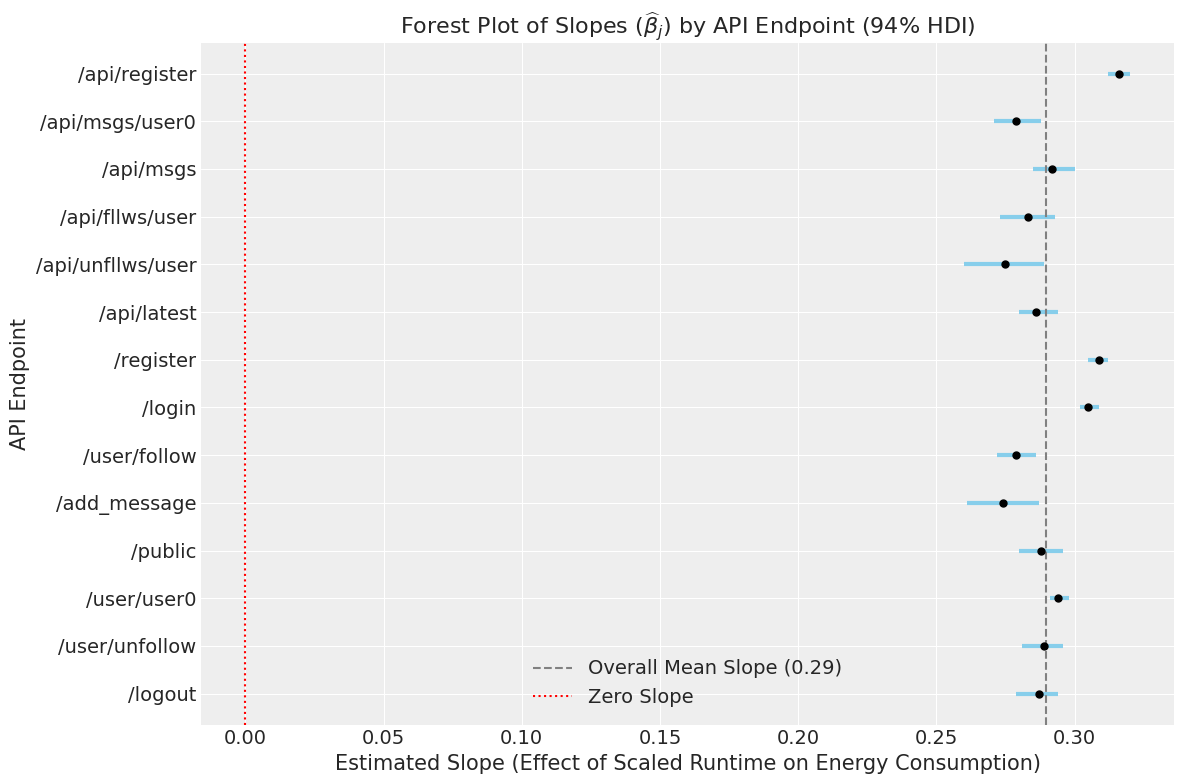

In [17]:
print("\n--- Generating Forest Plot for Beta (Slopes by Endpoint) ---")

# Extract posterior means and HDIs for beta parameters
beta_summary = az.summary(idata_h3_final, var_names=['beta'], hdi_prob=0.94)
beta_means = beta_summary['mean'].values
beta_hdi_lower = beta_summary['hdi_3%'].values
beta_hdi_upper = beta_summary['hdi_97%'].values

# Calculate errors for error bars (distance from mean to HDI bounds)
beta_errors = np.array([beta_means - beta_hdi_lower, beta_hdi_upper - beta_means])

# Ensure endpoint_names has the correct length matching the number of beta parameters
num_beta_params = len(beta_means)
if len(endpoint_names) != num_beta_params:
    print(f"Warning: Length of endpoint_names ({len(endpoint_names)}) does not match number of beta parameters ({num_beta_params}). Using generic labels.")
    plot_labels = [f"Endpoint {i}" for i in range(num_beta_params)]
else:
    plot_labels = endpoint_names

y_ticks = np.arange(num_beta_params)

plt.figure(figsize=(12, 8)) # Adjusted for potentially long endpoint names
plt.errorbar(beta_means, y_ticks, xerr=beta_errors, fmt='o', color='black',
             ecolor='skyblue', elinewidth=3, capsize=0, markersize=5)
plt.yticks(y_ticks, plot_labels)
plt.gca().invert_yaxis()  # To display first endpoint at the top
plt.axvline(np.mean(beta_means), color='grey', linestyle='--', label=f'Overall Mean Slope ({np.mean(beta_means):.2f})') # Line at overall mean of displayed betas
plt.axvline(0, color='red', linestyle=':', label='Zero Slope') # Line at zero slope for reference
plt.xlabel('Estimated Slope (Effect of Scaled Runtime on Energy Consumption)')
plt.ylabel('API Endpoint')
plt.title('Forest Plot of Slopes ($\widehat{\\beta}_j$) by API Endpoint (94% HDI)')
plt.legend()
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()


### 5.3. Interpretation of Results for H3

(This section should be filled in after visually inspecting the generated forest plot from the code above. Based on the plots you previously shared, the interpretation would be similar to this):

The forest plot displays the 94% HDIs for the estimated slope ($\beta_j$) of scaled runtime on energy consumption for each of the 14 API endpoints.

* **Variability in Slopes**: The plot clearly shows that the estimated slopes are not identical across all endpoints. The central points (posterior means) of the HDIs vary, and the intervals themselves are located at different positions along the x-axis.
* **Distinct Effects**: For several endpoints, the 94% HDIs do not substantially overlap, or do not overlap at all. For example, the slope for `/api/register` (which appears to be one of the highest) is credibly different from the slope for `/api/unfllws/user` (which appears to be one of the lower ones). This indicates that a one-unit increase in scaled runtime has a credibly larger positive impact on energy consumption for `/api/register` compared to `/api/unfllws/user`.
* **All Slopes Positive**: All estimated slopes are positive, as indicated by their HDIs being entirely to the right of the "Zero Slope" reference line. This is expected: increased runtime generally leads to increased energy consumption. The key finding for H3 is the *difference* in the magnitude of this positive effect.

**Conclusion for Hypothesis H3:**
The Bayesian hierarchical model provides strong evidence in support of Hypothesis H3.
1.  The hyperparameter $\sigma_{\beta}$ (representing the standard deviation of slopes across endpoints) has a 94% HDI that is credibly above zero ([0.009, 0.021]). This statistically confirms that there is genuine variation in how runtime affects energy consumption across the different API endpoints.
2.  The forest plot of individual endpoint slopes ($\beta_j$) visually demonstrates this variation, with several endpoints showing credibly different impacts of runtime on energy consumption.

Therefore, we conclude that **runtime has a stronger impact on energy consumption for some API endpoints than others.**

## 6. Overall Conclusion (for H3 Analysis)

The Bayesian varying-intercept, varying-slope model, after ensuring good sampling quality through non-centered parameterization, has allowed us to effectively test Hypothesis H3. The analysis reveals that the relationship between runtime and energy consumption is not constant across all API endpoints in the dataset. Specifically, the magnitude of the positive effect of runtime on energy consumption varies significantly depending on the API endpoint being considered.

This finding is important as it suggests that efforts to optimize for energy efficiency might need to be tailored to specific endpoints. Endpoints where runtime has a particularly strong impact on energy consumption could be high-priority targets for performance optimization to achieve greater energy savings. Further investigation could explore the characteristics of these high-impact endpoints to understand the underlying reasons for this stronger relationship.


## 7. Further Analysis: The Multilevel Nature of the H3 Model (Task 11)

The model designed to test Hypothesis H3 (that the effect of runtime on energy consumption varies across API endpoints) is inherently a **multilevel model**, also known as a hierarchical model. This section discusses why this structure was chosen and is meaningful in the context of the provided data.

### 7.1. Understanding Multilevel Models

In a multilevel model, parameters are not assumed to be entirely independent or entirely identical across different groups. Instead, group-specific parameters (in our case, for each API endpoint) are modeled as being drawn from a common, higher-level distribution. This structure acknowledges that while individual API endpoints may have unique characteristics, they also share commonalities (e.g., they are all API endpoints, likely subject to similar underlying factors affecting energy use).

### 7.2. The H3 Model as a Multilevel Structure

Our final model for H3 (`model_h3_final`) explicitly implements this:

* **Level 1 (Observation Level):** For each observation $i$ belonging to endpoint $j$:
    $$E_i \sim \text{Normal}(\alpha_j + \beta_j \cdot R_{scaled,i}, \sigma_{obs})$$
    Here, $\alpha_j$ (intercept) and $\beta_j$ (slope for runtime) are specific to each API endpoint $j$.

* **Level 2 (Endpoint Level):** Instead of estimating each $\alpha_j$ and $\beta_j$ completely independently, we model them as coming from common distributions:
    * Intercepts: $\alpha_j \sim \text{Normal}(\mu_{\alpha}, \sigma_{\alpha})$
    * Slopes: $\beta_j \sim \text{Normal}(\mu_{\beta}, \sigma_{\beta})$

* **Hyperpriors (Top Level):** The parameters of these common distributions ($\mu_{\alpha}, \sigma_{\alpha}, \mu_{\beta}, \sigma_{\beta}$) are themselves given priors (hyperpriors), allowing the model to learn the overall average intercept and slope, as well as the *variability* of these intercepts and slopes across the endpoints.

This hierarchical structure is what makes the model "multilevel." The non-centered parameterization used for $\alpha_j$ and $\beta_j$ (i.e., defining `alpha_offset` and `beta_offset`) is a computational technique to improve sampling for such models but does not change the underlying hierarchical nature.

### 7.3. Advantages and Meaningfulness in This Context

Adopting a multilevel approach for analyzing H3 offers several advantages:

1.  **Partial Pooling (Shrinkage):** This is a key benefit. Endpoints with fewer data points or more variable data can "borrow strength" from the overall distribution of intercepts and slopes learned from all endpoints. This leads to more stable and reliable estimates for individual $\alpha_j$ and $\beta_j$ parameters, pulling extreme estimates from sparse-data groups towards the overall mean effect. This is more realistic than assuming each endpoint is entirely independent (no pooling) or that all endpoints have the exact same intercept/slope (complete pooling).

2.  **Direct Estimation of Variability Across Groups:** The model directly estimates $\sigma_{\alpha}$ (the standard deviation of intercepts across endpoints) and, crucially for H3, $\sigma_{\beta}$ (the standard deviation of slopes across endpoints). As discussed in Section 5.1, the posterior distribution of $\sigma_{\beta}$ being credibly above zero was direct evidence supporting H3 – that there is genuine variation in the runtime effect. A non-multilevel approach would not provide such a direct, interpretable measure of this group-level variability.

3.  **More Realistic Assumptions:** It is plausible that different API endpoints within web applications share some underlying characteristics influencing their energy consumption patterns, while still exhibiting individual differences. A multilevel model naturally captures this structure by allowing parameters to vary by group but constraining this variation through common higher-level distributions.

4.  **Improved Generalization:** By partially pooling information, multilevel models can often provide better predictions for existing groups and potentially for new, unobserved groups (though the latter is not a focus of this specific hypothesis).

In summary, the varying-intercept, varying-slope model used for H3 is a meaningful multilevel model because it appropriately reflects the grouped structure of the data (observations nested within API endpoints). It allows for more robust estimation of endpoint-specific effects and directly quantifies the variability of these effects, which was central to addressing Hypothesis H3. The successful fitting of this model (after reparameterization) demonstrates its suitability for this dataset and research question.


## 8. Further Analysis: Counterfactual Predictions for H3 (Task 8)

To further explore the implications of Hypothesis H3 (that runtime has a varying impact on energy consumption across endpoints), we perform a counterfactual analysis. This involves using our fitted Bayesian model (`idata_h3_final`) to predict energy consumption under a hypothetical scenario: a runtime value significantly larger than those observed in the original dataset.

### 8.1. Rationale and Setup

The original dataset had `runtime_obs` values with a mean of approximately 0.125 seconds and a maximum of about 0.775 seconds. For this counterfactual analysis, we selected an original runtime value of **1.5 seconds**, which is roughly double the observed maximum. This value was then scaled using the same mean and standard deviation derived from the original `runtime_obs` to ensure consistency with the model's training data (resulting in a scaled counterfactual runtime of approximately 14.64).

We then generated posterior predictive samples for energy consumption for each of the 14 API endpoints, assuming this large, scaled runtime.

The Python code for this process is shown below.


--- Task 8: Counterfactual Analysis ---
Original counterfactual runtime chosen: 1.5 seconds
Scaled counterfactual runtime used in model: 14.64

Generated 14 sets of posterior predictions.
Shape of predictions for the first endpoint: (8000,)


/var/folders/2y/yqnrgs455nqbkzys9jk4k0sm0000gn/T/ipykernel_66723/1698548337.py:47: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


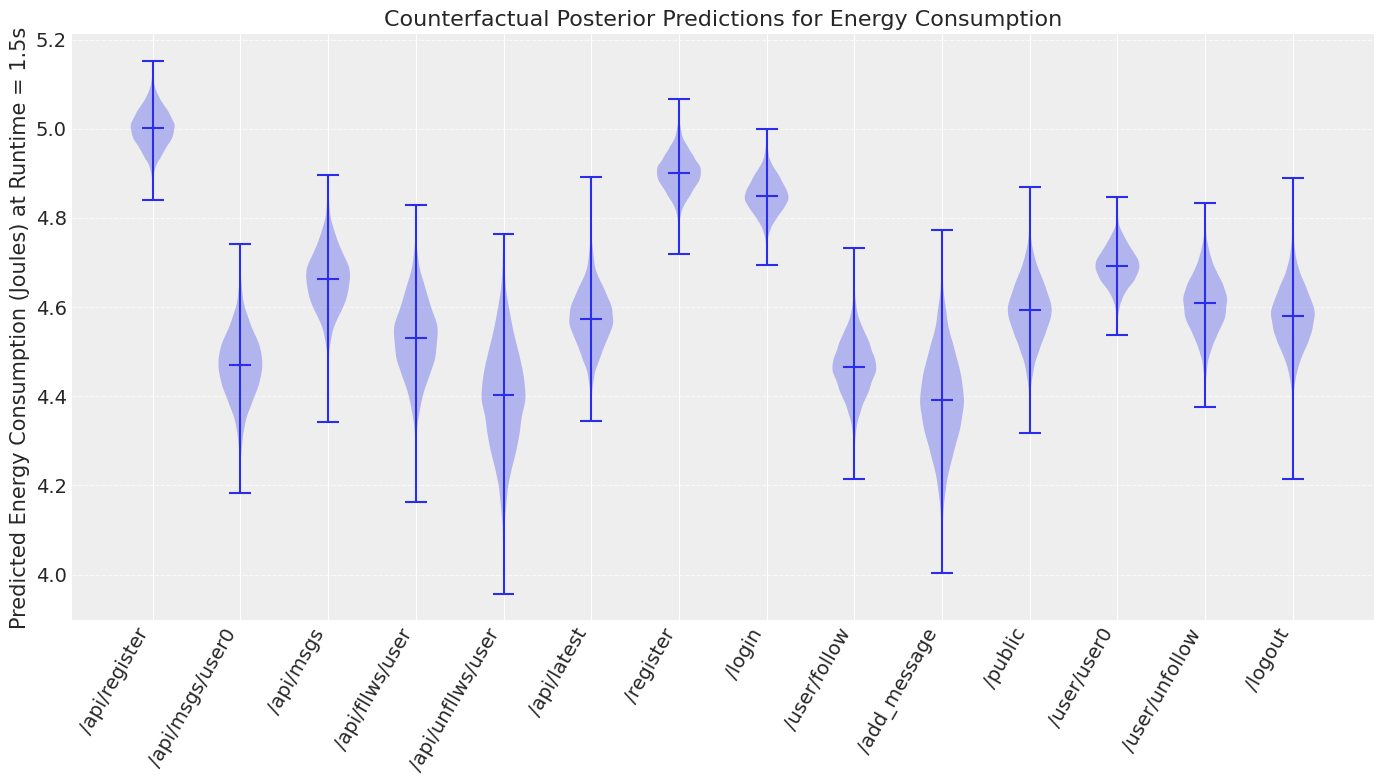

In [22]:
print("--- Task 8: Counterfactual Analysis ---")

# Chosen original counterfactual runtime
runtime_counterfactual_orig = 1.5
print(f"Original counterfactual runtime chosen: {runtime_counterfactual_orig} seconds")

# Scale this using the mean and std from the *original* dataset
if runtime_std > 1e-9:
    runtime_counterfactual_scaled = (runtime_counterfactual_orig - runtime_mean) / runtime_std
else:
    runtime_counterfactual_scaled = runtime_counterfactual_orig - runtime_mean
print(f"Scaled counterfactual runtime used in model: {runtime_counterfactual_scaled:.2f}")

posterior_predictions_counterfactual = []

for i in range(num_unique_endpoints):
    alpha_posterior = idata_h3_final.posterior['alpha'].sel(alpha_dim_0=i).values.flatten()
    beta_posterior = idata_h3_final.posterior['beta'].sel(beta_dim_0=i).values.flatten()
    sigma_obs_posterior = idata_h3_final.posterior['sigma_obs'].values.flatten()

    mu_counterfactual_posterior_endpoint = alpha_posterior + beta_posterior * runtime_counterfactual_scaled
    
    energy_pred_counterfactual_endpoint = np.random.normal(
        loc=mu_counterfactual_posterior_endpoint,
        scale=sigma_obs_posterior
    )
    posterior_predictions_counterfactual.append(energy_pred_counterfactual_endpoint)

print(f"\nGenerated {len(posterior_predictions_counterfactual)} sets of posterior predictions.")
if posterior_predictions_counterfactual:
    print(f"Shape of predictions for the first endpoint: {posterior_predictions_counterfactual[0].shape}")

# Plotting the counterfactual predictions
plt.figure(figsize=(14, 8))
plt.violinplot(dataset=[pred for pred in posterior_predictions_counterfactual], showmeans=False, showmedians=True)

# Use endpoint_names for labels if available
if 'endpoint_names' in locals() and len(endpoint_names) == num_unique_endpoints:
    plt.xticks(np.arange(1, num_unique_endpoints + 1), endpoint_names, rotation=60, ha="right")
else:
    print("Warning: endpoint_names not available or length mismatch. Using generic labels for plot.")
    plt.xticks(np.arange(1, num_unique_endpoints + 1), [f"Endpoint {i}" for i in range(num_unique_endpoints)], rotation=60, ha="right")

plt.ylabel(f"Predicted Energy Consumption (Joules) at Runtime = {runtime_counterfactual_orig}s")
plt.title(f"Counterfactual Posterior Predictions for Energy Consumption")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### 8.2. Interpretation of Counterfactual Results

The violin plot (Figure above) visualizes the posterior predictive distributions of energy consumption for each API endpoint under the counterfactual scenario of a runtime of 1.5 seconds (scaled to 14.64 for model input).

Several key observations emerge:

* **Amplified Differences**: At this significantly larger runtime, the differences in predicted energy consumption between API endpoints become more pronounced. Endpoints such as `/api/register` and `/register` (which had higher $\beta_j$ slope estimates in the H3 model) show substantially higher median predicted energy consumption (around 5.0 J and 4.9 J, respectively) compared to endpoints like `/api/unfllws/user` or `/user/follow` (medians around 4.3-4.5 J).
* **Effect of Varying Slopes**: This fanning out of predictions is a direct consequence of the varying slopes ($\beta_j$) identified in the H3 analysis. Endpoints where runtime has a stronger positive effect on energy (higher $\beta_j$) see their predicted energy consumption increase more sharply with the extrapolated runtime. If the slopes had been uniform, the distributions would be centered more closely, differing primarily due to their intercepts ($\alpha_j$).
* **Uncertainty**: The width of each violin indicates the uncertainty in the prediction for that endpoint. While some predictions are relatively tight, others might show greater spread, reflecting the overall model uncertainty and the uncertainty in the specific $\alpha_j$ and $\beta_j$ for that endpoint when projected to this extreme runtime.

**Conclusion for Task 8:**
The counterfactual analysis demonstrates that extrapolating to a runtime value much larger than those in the dataset **amplifies the differences in predicted energy consumption between API endpoints**. This reinforces the finding from H3 that the impact of runtime is not uniform. For endpoints where runtime is a stronger driver of energy use, their projected energy consumption diverges more significantly from other endpoints at high runtimes. This highlights the practical importance of identifying and optimizing such high-impact endpoints, as their energy costs could escalate disproportionately under heavy load or longer processing times.
